In [10]:
seed = 136194553992213785217382377961235308297

In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math


# 0 Set Up

In [12]:
train_df = pd.read_csv("/Users/wilhelmlannin/Documents/Python Stuff/MNIST_stuff/MNIST_CSV/mnist_train.csv",header=None)
train_df

# each row is a training case
# 0th column tells us the label for the case in that row
# rest of the columns tell us the pixel vals (reading left to right from top left)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 1 Nnet Class

In [ ]:
# see my rough code notebook for justifications/derivations for the code used in the class below

# and see the attached pdfs for mathematical derivations of the gradients of each parameter

In [ ]:
class Nnet:
    def __init__(self,train_df,nu=0.01,random_seed=seed):
        #train_df: dataframe of mnist training cases 
        #nu: learning rate, deafult 0.01
        #random_seed: number that sets the randomness of ranom number generator for replicability

        self.train_df = train_df
        #set seed for random number generation
        self.rng = np.random.default_rng(seed)

        # map pixel values between 0 and 1
        self.train_arr_01 = np.array(train_df.iloc[:,1:]) / 255

        # true labels for each image
        self.t = np.array(self.train_df[0])
        #number of training images
        self.K = len(self.t)

        #number of neurons in each layer
        self.L = {0:784, 1:128, 2:64, 3:10}
        #bias vals initialised at 0
        self.b = {1:0, 2:0, 3:0}
        # weight matrices (randomly initialised using xavier)
        self.W = {1:self.rng.normal(loc=0,scale=(1/self.L[0])**0.5,size=[self.L[0],self.L[1]]),
            2:self.rng.normal(loc=0,scale=(1/self.L[1])**0.5,size=[self.L[1],self.L[2]]),
            3:self.rng.normal(loc=0,scale=(1/self.L[2])**0.5,size=[self.L[2],self.L[3]])}
        
        #exponential e^ function
        self.allexp = np.vectorize(math.exp)
        #ReLU activation function
        self.f = np.vectorize(lambda x: max([0,x]),otypes=[float])

        #learning rate parameter nu for gradient steps
        self.nu = nu

        #training related data
        self.wsums = {l:{} for l in self.L.keys()}
        self.phat_all_k = []  # filled later
        self.g_b = self.b.copy()
        self.g_W = self.W.copy()
        self.gradient_steps_taken = 0

        

    def view_train_image_k(self,k):
        #silly way that I define the pixels at the start and end of each row
        bound=1
        bounds_list = []
        while bound < 784:
            bound_l = bound
            bound += 28
            bound_u = bound
            bounds_list += [(bound_l,bound_u)]
        #now use these bounds to show the train image
        print("label:",self.train_df.iloc[k,0])
        img = np.array([list(self.train_df.iloc[k,x[0]:x[1]]) for x in bounds_list])
        plt.imshow(img, cmap='gray')
        plt.show()

    def generate_phat_k(self,k):
        vec = self.train_arr_01[k]
        p3 = self.f(self.b[3] + ( self.f(self.b[2] + ( self.f(self.b[1] + ( vec @ self.W[1] )) @ self.W[2])) @ self.W[3]))
        expvec = self.allexp(p3)
        phat = expvec/sum(expvec)
        return phat
    
    def predict_k(self,k):
        vec = self.train_arr_01[k]
        p3 = self.f(self.b[3] + ( self.f(self.b[2] + ( self.f(self.b[1] + ( vec @ self.W[1] )) @ self.W[2])) @ self.W[3]))
        expvec = self.allexp(p3)
        phat = expvec/sum(expvec)
        #return the first label that has the highest softmax probability in phat
        return [idx for idx,val in enumerate(phat) if val >= max(phat)][0]
                    
    def accuracy(self):
        vec_predict = np.vectorize(self.predict_k)
        pred_labels1 = vec_predict(np.array(range(len(self.t))))
        # TOTAL ACCURACY (percent of cases that the model predicted correctly)
        true_val_checklist = [pred_labels1[k]==true_val for k,true_val in enumerate(self.t)]
        total_accuracy = sum(true_val_checklist)/len(true_val_checklist)
        return total_accuracy
        
    def all_performance(self):
        vec_predict = np.vectorize(self.predict_k)
        pred_labels1 = vec_predict(np.array(range(len(self.t))))

        # TOTAL ACCURACY (percent of cases that the model predicted correctly)
        true_val_checklist = [pred_labels1[k]==true_val for k,true_val in enumerate(self.t)]
        total_accuracy = sum(true_val_checklist)/len(true_val_checklist)
        print(total_accuracy)
        print("total accuracy =", round(100*total_accuracy,2),"%")

        # digit accuracy is the percent of training cases containing digit n that the model predicted correctly
        digit_accuracy = {}
        for digit in range(10):
            train_cases_containing_digit = [k for k,true_val in enumerate(self.t) if true_val==digit]
            # now calculate how many of these cases we predicted correctly
            checklist = [pred_labels1[k]==digit for k in train_cases_containing_digit]
            digit_accuracy[digit] = sum(checklist)/len(checklist)
        print("digit accuracy:")
        print(digit_accuracy)

        # digit recall should tell us the percent of cases the model predicted as that digit that were actually that digit
        digit_recall = {}
        for digit in range(10):
            cases_we_predicted_digit = [k for k,true_val in enumerate(pred_labels1) if true_val==digit]
            # now calculate how many of these cases actually contained this digit correctly
            checklist = [self.t[k]==digit for k in cases_we_predicted_digit]
            digit_recall[digit] = sum(checklist)/len(checklist) if len(checklist) != 0 else None
        print("digit_recall:")
        print(digit_recall)

    def calc_wsums_and_phat_all_k(self):
        # we need every single weight sum for every single k, so create a data structure that allows us to store these conveniently

        self.wsums[1] = {k:self.b[1] + (self.train_arr_01[k] @ self.W[1]) for k in range(len(self.t))}
        # now we need to define the second layer weight sums using wsums[1]
        self.wsums[2] = {k:self.b[2] + self.f(self.wsums[1][k]) @ self.W[2] for k in range(len(self.t))}
        # and define the 3rd layer weight sums using the second weight sums we just calculated
        self.wsums[3] = {k:self.b[3] + self.f(self.wsums[2][k]) @ self.W[3] for k in range(len(self.t))}
        #this way, we get all the weight sums we need and only have to do each matrix multiplication once! work samrter not harder?

        # now we need to arrive at phat for each training case k from the layer 3 weightsums in wsums[3]
        expvec_all_k = [self.allexp(self.f(self.wsums[3][k])) for k in range(len(self.t))]
        self.phat_all_k = [expvec_all_k[k]/sum(expvec_all_k[k]) for k in range(len(self.t))]


    def calc_bias_gradients(self):
        # biases
        self.g_b[3] = -sum([(self.wsums[3][k][self.t[k]] > 0) - sum([self.phat_all_k[k][z] for z in range(self.L[3]) if self.wsums[3][k][z] > 0]) for k in range(len(self.t))]) / self.K


        self.g_b[2] = -sum([(sum([self.W[3][i][self.t[k]] for i in range(self.L[2]) if self.wsums[2][k][i] > 0]) if self.wsums[3][k][self.t[k]] > 0 else 0) \
        - sum([self.phat_all_k[k][z]*sum([self.W[3][i][z] for i in range(self.L[2]) if self.wsums[2][k][i] > 0]) for z in range(self.L[3]) if self.wsums[3][k][z] > 0]) for k in range(len(self.t))]) / self.K

        self.g_b[1] = -sum(
            [
                (
                    np.sum(
                    np.multiply(self.W[3][np.nonzero(self.wsums[2][k][:] > 0),self.t[k]] , np.sum(self.W[2][np.nonzero(self.wsums[1][k][:] > 0)][:,np.nonzero(self.wsums[2][k][:] > 0)],initial=0,axis=0))
                        ) if self.wsums[3][k][self.t[k]] > 0 else 0) \
        - sum(
            [
                self.phat_all_k[k][z]*(np.sum(
                    np.multiply(self.W[3][np.nonzero(self.wsums[2][k][:] > 0),z] , np.sum(self.W[2][np.nonzero(self.wsums[1][k][:] > 0)][:,np.nonzero(self.wsums[2][k][:] > 0)],initial=0,axis=0))
                        ) if self.wsums[3][k][z] > 0 else 0) for z in range(self.L[3]) if self.wsums[3][k][z] > 0]
                        ) for k in range(len(self.t))]) / self.K
    
    def calc_weight_gradients(self):

        self.g_W[3] = np.transpose(-np.sum(np.array([np.multiply(np.array([np.repeat([( (b==self.t[k]) - self.phat_all_k[k][b] )],repeats=self.L[2]) for b in range(self.L[3])]),np.transpose(np.array(self.wsums[3][k] > 0,ndmin=2)) @ np.array(self.f(self.wsums[2][k]),ndmin=2))
                                    for k in range(len(self.t))]),axis=0) / self.K)
        
        # so, here is the final code I'll use for layer 2 weights
        i3W3_all_k_all_z_fast = np.array(
            [
                [np.array(self.W[3][:,z]) if (self.wsums[3][k][z] > 0) else np.zeros(self.L[2]) for z in range(self.L[3])
                ] for k in range(len(self.t))
                ]
                )

        self.g_W[2] = -sum([np.multiply(
            #start np.multiply with the transpose of new_dotted
            np.transpose(np.transpose(np.array(self.wsums[2][k] > 0,ndmin=2)) @ np.array(self.f(self.wsums[1][k]),ndmin=2)),
                    #bracketsterm_repeated is defined as the right-part of this np.multiply
                    np.repeat([i3W3_all_k_all_z_fast[k][self.t[k]] - np.sum(np.array([self.phat_all_k[k][z] * i3W3_all_k_all_z_fast[k][z] for z in range(self.L[3])]),axis=0)],repeats=self.L[1],axis=0))
                    for k in range(len(self.t))]) / self.K
        
        # so in totality here is g_W[1]
        i3thensum_all_k_all_z_3 = [
                [
                    np.sum(np.multiply(self.W[2][:,np.nonzero(self.wsums[2][k] > 0)[0]],
                                #this is "repeated" we defined earlier
                                np.repeat([self.W[3][np.nonzero(self.wsums[2][k] > 0)[0],z]],repeats=self.L[1],axis=0)),axis=1,initial=0)
                                    if (self.wsums[3][k][z] > 0) else np.zeros(self.L[1]) for z in range(self.L[3])
                ] for k in range(len(self.t))
            ]

        self.g_W[1] = -sum([np.multiply(
            #start np.multiply with the same idea as new_dotted in the g_W[2] case, but with layers 2 and 1 swapped for 1 and 0 (resp.)
            np.transpose(np.transpose(np.array(self.wsums[1][k] > 0,ndmin=2)) @ np.array(self.train_arr_01[k],ndmin=2)),
                    #then this second part of np.multiply is similar to the g_W[2] case, using i3thensum_all_k_all_z_3 in place of i3W3_all_k_all_z (and repeat L[0] times)
                    np.repeat([i3thensum_all_k_all_z_3[k][self.t[k]] - np.sum(np.array([self.phat_all_k[k][z] * i3thensum_all_k_all_z_3[k][z] for z in range(self.L[3])]),axis=0)],repeats=self.L[0],axis=0))
                    for k in range(len(self.t))]) / self.K
        
    def take_1_gradient_step(self):
        self.calc_wsums_and_phat_all_k()
        self.calc_bias_gradients()
        self.calc_weight_gradients()

        # now we have all the gradients calculated for this step, take the step
        for l in [1,2,3]:
            #gradient step for bias and weioghts corresponding to layer l
            self.b[l] -= self.nu*self.g_b[l]
            self.W[l] -= self.nu*self.g_W[l]

        #increase number of steps taken
        self.gradient_steps_taken += 1

    def train_network_v1(self,eps=0.000001,max_wait_steps=3,max_steps=500):
        #my first attempt at a function to train the network via many calls to self.take_1_gradient_step

        # keep taking steps until either max_steps is hit or we go {max_wait_steps} many iterations without accuracy increasing by eps
        
        # accuracy pre step
        pre_accuracy = self.accuracy()

        #initialise steps_waited
        steps_waited=0

        while self.gradient_steps_taken < max_steps:

            # step
            self.take_1_gradient_step()

            #accuracy after the step
            post_accuracy = self.accuracy()
            print(f"accuracy after {self.gradient_steps_taken} steps:",post_accuracy)

            # if the change in accuracy is bigger than eps, continue
            if abs(pre_accuracy - post_accuracy) > eps:
                pre_accuracy = post_accuracy
                continue
            else:
                pre_accuracy = post_accuracy
                #add to steps_waited
                steps_waited += 1
                #if we have surpassed max steps waited we stop
                if steps_waited > max_wait_steps:
                    return





# 2 Quick Train

In [44]:
#it is sunday night and my code isn't that efficient so first experiment is trying a quick train with low iterations

In [45]:
Quicknet = Nnet(train_df,nu=0.02,random_seed=seed)


In [46]:
#let it do 70 steps, use 0.02 learning rate
Quicknet.train_network_v1(eps=0.000001,max_wait_steps=10,max_steps=70)



accuracy after 1 steps: 0.07408333333333333
accuracy after 2 steps: 0.07733333333333334
accuracy after 3 steps: 0.08215
accuracy after 4 steps: 0.08638333333333334
accuracy after 5 steps: 0.09041666666666667
accuracy after 6 steps: 0.0948
accuracy after 7 steps: 0.09956666666666666
accuracy after 8 steps: 0.10476666666666666
accuracy after 9 steps: 0.1099
accuracy after 10 steps: 0.11568333333333333
accuracy after 11 steps: 0.12166666666666667
accuracy after 12 steps: 0.12745
accuracy after 13 steps: 0.13338333333333333
accuracy after 14 steps: 0.13925
accuracy after 15 steps: 0.1455
accuracy after 16 steps: 0.15226666666666666
accuracy after 17 steps: 0.1596
accuracy after 18 steps: 0.16708333333333333
accuracy after 19 steps: 0.1743
accuracy after 20 steps: 0.18136666666666668
accuracy after 21 steps: 0.18903333333333333
accuracy after 22 steps: 0.19643333333333332
accuracy after 23 steps: 0.20431666666666667
accuracy after 24 steps: 0.21191666666666667
accuracy after 25 steps: 0.219

In [47]:
#add another 10 steps
Quicknet.train_network_v1(eps=0.000001,max_wait_steps=10,max_steps=80)



accuracy after 71 steps: 0.5442166666666667
accuracy after 72 steps: 0.54775
accuracy after 73 steps: 0.5510333333333334
accuracy after 74 steps: 0.5544833333333333
accuracy after 75 steps: 0.5582833333333334
accuracy after 76 steps: 0.5613
accuracy after 77 steps: 0.5644
accuracy after 78 steps: 0.5676
accuracy after 79 steps: 0.57085
accuracy after 80 steps: 0.5741166666666667


In [51]:
#add another 10 steps
Quicknet.train_network_v1(eps=0.000001,max_wait_steps=10,max_steps=83)



accuracy after 81 steps: 0.5773166666666667
accuracy after 82 steps: 0.5809
accuracy after 83 steps: 0.58355


In [52]:
Quicknet.all_performance()
# please note I made a mistake in my code for digit-level accuracy and recall, corrected later

0.58355
total accuracy = 58.36 %
digit accuracy:
{0: 0.1485733580955597, 1: 0.13823791159893206, 2: 0.12772742531050688, 3: 0.16783558962648834, 4: 0.07839780896953098, 5: 0.012543811104962183, 6: 0.03751267320040554, 7: 0.21292897047086992, 8: 0.07502990941719365, 9: 0.0}
digit_recall:
{0: 0.10023612750885479, 1: 0.11305215872223609, 2: 0.09843571156047311, 3: 0.10330313843901547, 4: 0.10782980376918594, 5: 0.08707482993197278, 6: 0.09758713136729223, 7: 0.10659773510585918, 8: 0.09267376330619913, 9: None}


# 3 Test Data

In [48]:
test_df = pd.read_csv("/Users/wilhelmlannin/Documents/Python Stuff/MNIST_stuff/MNIST_CSV/mnist_test.csv",header=None)
test_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
test_arr_01 = np.array(test_df.iloc[:,1:]) / 255

label: 0


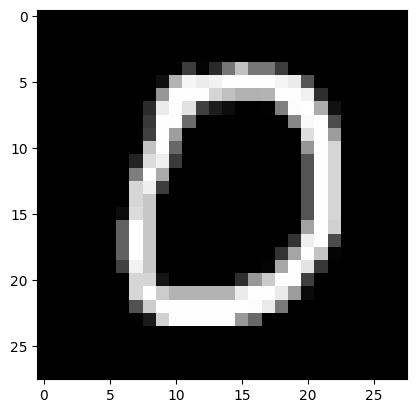

In [53]:
def view_kth_test_case(k):
    # view image
    #silly way that I define the pixels at the start and end of each row
    bound=1
    bounds_list = []
    while bound < 784:
        bound_l = bound
        bound += 28
        bound_u = bound
        bounds_list += [(bound_l,bound_u)]
    #now use these bounds to show the train image
    print("label:",test_df.iloc[k,0])
    img = np.array([list(test_df.iloc[k,x[0]:x[1]]) for x in bounds_list])
    plt.imshow(img, cmap='gray')
    plt.show()

view_kth_test_case(10)

In [54]:
# predict kth row of the test data

def predict_kth_test_case(k,Nnet_instance):
        vec = test_arr_01[k]
        p3 = Nnet_instance.f(Nnet_instance.b[3] + ( Nnet_instance.f(Nnet_instance.b[2] + ( Nnet_instance.f(Nnet_instance.b[1] + ( vec @ Nnet_instance.W[1] )) @ Nnet_instance.W[2])) @ Nnet_instance.W[3]))
        expvec = Nnet_instance.allexp(p3)
        phat = expvec/sum(expvec)
        #return the first label that has the highest softmax probability in phat
        return [idx for idx,val in enumerate(phat) if val >= max(phat)][0]


In [55]:
#default untrained net for comparison
Defaultnet = Nnet(train_df,nu=0.02,random_seed=seed)

label: 1


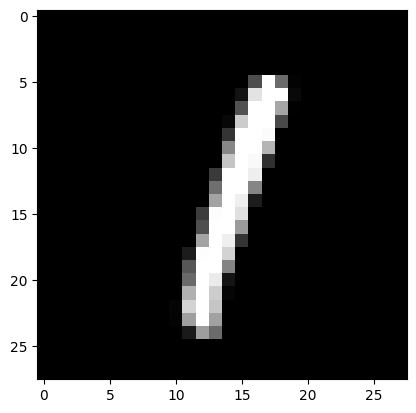

quicknet's prediction:
1

defaultnet's prediction:
0


In [62]:
k=5
view_kth_test_case(k)
print("quicknet's prediction:")
print(predict_kth_test_case(k,Quicknet))
print()
print("defaultnet's prediction:")
print(predict_kth_test_case(k,Defaultnet))

In [63]:
import copy
#make a copy of quicknet from 20250302
Quicknet_20250302 = copy.deepcopy(Quicknet)

In [64]:
#now let quicknet continue training overnight
Quicknet.train_network_v1(eps=0.00000001,max_wait_steps=5,max_steps=360)



accuracy after 84 steps: 0.58695
accuracy after 85 steps: 0.59055
accuracy after 86 steps: 0.5935333333333334
accuracy after 87 steps: 0.59625
accuracy after 88 steps: 0.5997333333333333
accuracy after 89 steps: 0.6034666666666667
accuracy after 90 steps: 0.6061833333333333
accuracy after 91 steps: 0.6093333333333333
accuracy after 92 steps: 0.6121
accuracy after 93 steps: 0.61485
accuracy after 94 steps: 0.6176333333333334
accuracy after 95 steps: 0.6200833333333333
accuracy after 96 steps: 0.62295
accuracy after 97 steps: 0.62585
accuracy after 98 steps: 0.6287166666666667
accuracy after 99 steps: 0.6313
accuracy after 100 steps: 0.6336666666666667
accuracy after 101 steps: 0.6363666666666666
accuracy after 102 steps: 0.6389
accuracy after 103 steps: 0.641
accuracy after 104 steps: 0.6432833333333333
accuracy after 105 steps: 0.6457
accuracy after 106 steps: 0.6480833333333333
accuracy after 107 steps: 0.6504
accuracy after 108 steps: 0.6527333333333334
accuracy after 109 steps: 0.65

In [65]:
#train some more
Quicknet.train_network_v1(eps=0.00000001,max_wait_steps=5,max_steps=460)


accuracy after 361 steps: 0.79725
accuracy after 362 steps: 0.7973833333333333
accuracy after 363 steps: 0.7974666666666667
accuracy after 364 steps: 0.7975333333333333
accuracy after 365 steps: 0.7976166666666666
accuracy after 366 steps: 0.79775
accuracy after 367 steps: 0.7979
accuracy after 368 steps: 0.7980166666666667
accuracy after 369 steps: 0.7981333333333334
accuracy after 370 steps: 0.7982333333333334
accuracy after 371 steps: 0.7983666666666667
accuracy after 372 steps: 0.79855
accuracy after 373 steps: 0.7987
accuracy after 374 steps: 0.7988333333333333
accuracy after 375 steps: 0.7989
accuracy after 376 steps: 0.7989333333333334
accuracy after 377 steps: 0.7991
accuracy after 378 steps: 0.79915
accuracy after 379 steps: 0.7993333333333333
accuracy after 380 steps: 0.7994
accuracy after 381 steps: 0.7994166666666667
accuracy after 382 steps: 0.7995666666666666
accuracy after 383 steps: 0.7996666666666666
accuracy after 384 steps: 0.79965
accuracy after 385 steps: 0.7997333

In [66]:
Quicknet.all_performance()
# please note I made a mistake in my code for digit-level accuracy and recall, corrected later

0.8057833333333333
total accuracy = 80.58 %
digit accuracy:
{0: 0.10552085092014182, 1: 0.1234055176505488, 2: 0.09516616314199396, 3: 0.10373511662045343, 4: 0.14464224580623075, 5: 0.08780667773473529, 6: 0.10645488340655627, 7: 0.1343974461292897, 8: 0.09861562126132285, 9: 0.0}
digit_recall:
{0: 0.0986970684039088, 1: 0.11195652173913044, 2: 0.09660351595835467, 3: 0.1015220207253886, 4: 0.09917452830188679, 5: 0.085675353432124, 6: 0.10073907455012854, 7: 0.10667856232475147, 8: 0.09199205823957644, 9: None}


In [67]:
#train some more
Quicknet.train_network_v1(eps=0.00000001,max_wait_steps=5,max_steps=666)


accuracy after 461 steps: 0.8058666666666666
accuracy after 462 steps: 0.8059
accuracy after 463 steps: 0.8059833333333334
accuracy after 464 steps: 0.80605
accuracy after 465 steps: 0.8060666666666667
accuracy after 466 steps: 0.8060666666666667
accuracy after 467 steps: 0.8061166666666667
accuracy after 468 steps: 0.8061666666666667
accuracy after 469 steps: 0.8062
accuracy after 470 steps: 0.8062666666666667
accuracy after 471 steps: 0.8063333333333333
accuracy after 472 steps: 0.8063333333333333
accuracy after 473 steps: 0.8063333333333333
accuracy after 474 steps: 0.8063833333333333
accuracy after 475 steps: 0.80645
accuracy after 476 steps: 0.8064833333333333
accuracy after 477 steps: 0.8065833333333333
accuracy after 478 steps: 0.8067
accuracy after 479 steps: 0.8067166666666666
accuracy after 480 steps: 0.8067666666666666
accuracy after 481 steps: 0.8068
accuracy after 482 steps: 0.8068833333333333
accuracy after 483 steps: 0.8068833333333333
accuracy after 484 steps: 0.8069
ac

In [68]:
#train some more
Quicknet.train_network_v1(eps=0.00000001,max_wait_steps=5,max_steps=517)


accuracy after 508 steps: 0.8082666666666667
accuracy after 509 steps: 0.8083833333333333
accuracy after 510 steps: 0.8084666666666667
accuracy after 511 steps: 0.8085166666666667
accuracy after 512 steps: 0.80855
accuracy after 513 steps: 0.8085833333333333
accuracy after 514 steps: 0.8086833333333333
accuracy after 515 steps: 0.8088333333333333
accuracy after 516 steps: 0.8089
accuracy after 517 steps: 0.8089666666666666


In [69]:
#train some more
Quicknet.train_network_v1(eps=0.00000001,max_wait_steps=5,max_steps=522)


accuracy after 518 steps: 0.8090333333333334
accuracy after 519 steps: 0.8091166666666667
accuracy after 520 steps: 0.8091666666666667
accuracy after 521 steps: 0.8091833333333334
accuracy after 522 steps: 0.8092333333333334


## test on own images

In [ ]:
# darya and I drew some of our own 28x28 pixel images to test the net on!

In [70]:
from PIL import Image

In [73]:

# Load the image

image = Image.open("drawnimg1.png").convert("L")  # Convert to grayscale

# Resize to 28x28
# image = image.resize((28, 28))

# Convert to NumPy array
array = np.array(image)

# Flatten the array into 784 elements
flattened_array = array.flatten()

# Print shape to verify
print(flattened_array.shape)  # Should print (784,)

# Display the first few pixel values
print(flattened_array[:10])

(784,)
[0 0 0 0 0 0 0 0 0 0]


In [81]:
def img_to_array(img_path):
    image = Image.open(img_path).convert("L")  # Convert to grayscale

    # Convert to NumPy array
    array = np.array(image)

    # Flatten the array into 784 elements
    return array.flatten()


In [ ]:
flattened_array

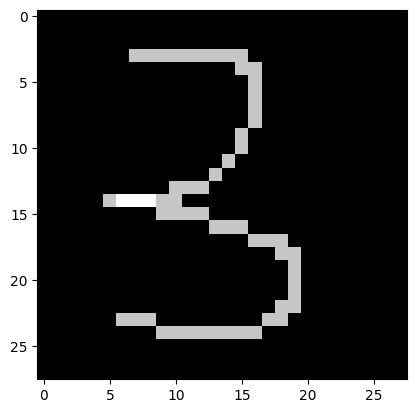

In [79]:
def view_image(pixel_array):
    # view image
    #silly way that I define the pixels at the start and end of each row
    bound=0
    bounds_list = []
    while bound < 783:
        bound_l = bound
        bound += 28
        bound_u = bound
        bounds_list += [(bound_l,bound_u)]
    img = np.array([list(pixel_array[x[0]:x[1]]) for x in bounds_list])
    plt.imshow(img, cmap='gray')
    plt.show()

view_image(flattened_array)

In [80]:
# predict
def predict_image(pixel_array,Nnet_instance):
        vec = pixel_array
        p3 = Nnet_instance.f(Nnet_instance.b[3] + ( Nnet_instance.f(Nnet_instance.b[2] + ( Nnet_instance.f(Nnet_instance.b[1] + ( vec @ Nnet_instance.W[1] )) @ Nnet_instance.W[2])) @ Nnet_instance.W[3]))
        expvec = Nnet_instance.allexp(p3)
        phat = expvec/sum(expvec)
        #return the first label that has the highest softmax probability in phat
        return [idx for idx,val in enumerate(phat) if val >= max(phat)][0]


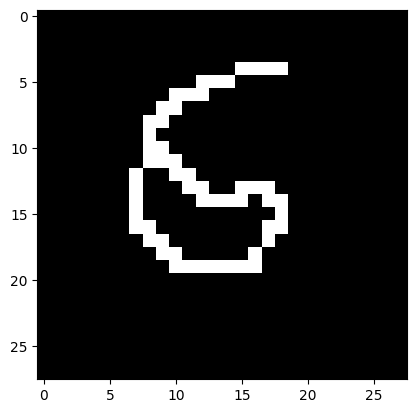

quicknet's prediction:
6

defaultnet's prediction:
5


In [85]:
pixel_array = img_to_array("drawnimg6.png")
view_image(pixel_array)
print("quicknet's prediction:")
print(predict_image(pixel_array,Quicknet))
print()
print("defaultnet's prediction:")
print(predict_image(pixel_array,Defaultnet))

#correct!


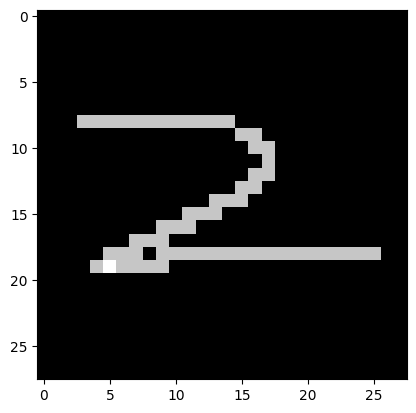

quicknet's prediction:
2

defaultnet's prediction:
5


In [86]:
pixel_array = img_to_array("drawnimg22.png")
view_image(pixel_array)
print("quicknet's prediction:")
print(predict_image(pixel_array,Quicknet))
print()
print("defaultnet's prediction:")
print(predict_image(pixel_array,Defaultnet))

#correct!


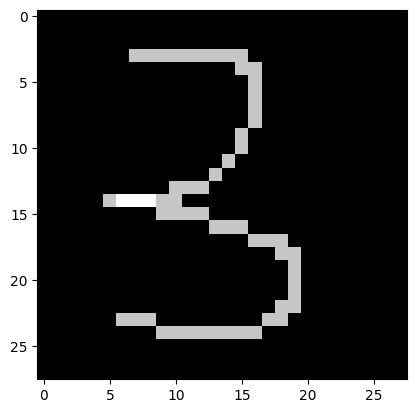

quicknet's prediction:
6

defaultnet's prediction:
2


In [ ]:
pixel_array = img_to_array("drawnimg1.png")
view_image(pixel_array)
print("quicknet's prediction:")
print(predict_image(pixel_array,Quicknet))
print()
print("defaultnet's prediction:")
print(predict_image(pixel_array,Defaultnet))

# it got this one wrong


In [87]:
#train some more
Quicknet.train_network_v1(eps=0.00000001,max_wait_steps=5,max_steps=999)


accuracy after 523 steps: 0.8093333333333333
accuracy after 524 steps: 0.8094
accuracy after 525 steps: 0.8094833333333333
accuracy after 526 steps: 0.8095
accuracy after 527 steps: 0.8095833333333333
accuracy after 528 steps: 0.8096333333333333
accuracy after 529 steps: 0.8096833333333333
accuracy after 530 steps: 0.8097166666666666
accuracy after 531 steps: 0.8097833333333333
accuracy after 532 steps: 0.8098666666666666
accuracy after 533 steps: 0.80995
accuracy after 534 steps: 0.8100166666666667
accuracy after 535 steps: 0.8100833333333334
accuracy after 536 steps: 0.81015
accuracy after 537 steps: 0.8102
accuracy after 538 steps: 0.81025
accuracy after 539 steps: 0.8102833333333334
accuracy after 540 steps: 0.8103333333333333
accuracy after 541 steps: 0.81035
accuracy after 542 steps: 0.8104333333333333
accuracy after 543 steps: 0.8104333333333333
accuracy after 544 steps: 0.81045
accuracy after 545 steps: 0.8104833333333333
accuracy after 546 steps: 0.8105
accuracy after 547 step

In [91]:
Quicknet

## all test data performance

In [92]:
# equivalent of the vector t of true labels for the test set:
test_t = list(test_df.iloc[:,0])
len(test_t)

10000

In [93]:
#quicknet specific version of predict kth test case function
def qnet_predict_kth_test_case(k):
        vec = test_arr_01[k]
        p3 = Quicknet.f(Quicknet.b[3] + ( Quicknet.f(Quicknet.b[2] + ( Quicknet.f(Quicknet.b[1] + ( vec @ Quicknet.W[1] )) @ Quicknet.W[2])) @ Quicknet.W[3]))
        expvec = Quicknet.allexp(p3)
        phat = expvec/sum(expvec)
        #return the first label that has the highest softmax probability in phat
        return [idx for idx,val in enumerate(phat) if val >= max(phat)][0]

In [95]:
# rework the method used to check performance in my nnet class
def test_performance():
    vec_predict = np.vectorize(qnet_predict_kth_test_case)
    pred_labels1 = vec_predict(np.array(range(len(test_t))))

    # TOTAL ACCURACY (percent of cases that the model predicted correctly)
    true_val_checklist = [pred_labels1[k]==true_val for k,true_val in enumerate(test_t)]
    total_accuracy = sum(true_val_checklist)/len(true_val_checklist)
    print(total_accuracy)
    print("total test-set accuracy =", round(100*total_accuracy,2),"%")

    # digit accuracy is the percent of training cases containing digit n that the model predicted correctly
    digit_accuracy = {}
    for digit in range(10):
        train_cases_containing_digit = [k for k,true_val in enumerate(test_t) if true_val==digit]
        # now calculate how many of these cases we predicted correctly
        checklist = [pred_labels1[k]==digit for k in train_cases_containing_digit]
        digit_accuracy[digit] = sum(checklist)/len(checklist)
    print("test-set digit accuracy:")
    print(digit_accuracy)

    # digit recall should tell us the percent of cases the model predicted as that digit that were actually that digit
    digit_recall = {}
    for digit in range(10):
        cases_we_predicted_digit = [k for k,true_val in enumerate(pred_labels1) if true_val==digit]
        # now calculate how many of these cases actually contained this digit correctly
        checklist = [test_t[k]==digit for k in cases_we_predicted_digit]
        digit_recall[digit] = sum(checklist)/len(checklist) if len(checklist) != 0 else None
    print("test-set digit recall:")
    print(digit_recall)


In [96]:
test_performance()
# overall I am happy to see how our neural net performs on the unseen test-set!

# interestingingly my network never predicted 9, I wonder if I made a mistake somewhere that caused this (maybe...
# the way I coded it to always predict the lowest digit in cases of ties means 9 is picked the least often?)

# overall the network seems to do the best job at identifying 1s and 0s

# 4 & 7 have high accuracy, but low recall, suggesting the network predicts these digits too often!

# 

0.8184
total test-set accuracy = 81.84 %
test-set digit accuracy:
{0: 0.9693877551020408, 1: 0.9674008810572687, 2: 0.8624031007751938, 3: 0.8910891089108911, 4: 0.9501018329938901, 5: 0.8385650224215246, 6: 0.930062630480167, 7: 0.9163424124513618, 8: 0.8542094455852156, 9: 0.0}
test-set digit recall:
{0: 0.9152215799614644, 1: 0.9336734693877551, 2: 0.8811881188118812, 3: 0.8620689655172413, 4: 0.6381668946648427, 5: 0.7906976744186046, 6: 0.8874501992031872, 7: 0.734789391575663, 8: 0.8015414258188824, 9: None}
